<h1 align="center">Сжатие изображения с применением вейвлет-преобразования.</h1>

В работе было многократно использовано D4 вейвлет-преобразование для того, чтобы получить большое количество низкочастотных коэффициентов. Далее выбирается пороговое значение, числа меньше по модулю которого зануляются. Полученные данные затем сжимаются алгоритмом LZMA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import lzma
import os
from tqdm.notebook import tqdm

In [2]:
def hpf_coeffs(c_lpf):
    N = len(c_lpf) 
    c_hpf = [(-1)**k * c_lpf[N - k - 1] for k in range(N)]
    return c_hpf

def pconv(data, c_lpf, c_hpf, delta = 0):
    N = len(c_lpf)
    M = len(data)
    out = []    
    for k in range(0, M, 2):
        sL = 0
        sH = 0
        for i in range(N):
            sL += data[(k + i - delta) % M] * c_lpf[i]
            sH += data[(k + i - delta) % M] * c_hpf[i]
        out.extend([sL, sH])             
    return out

def coeffs_inverse(c_lpf, c_hpf):
    ic_lpf = []
    ic_hpf = []
    for k in range(0, len(c_lpf), 2):
        ic_lpf.extend([c_lpf[k-2], c_hpf[k-2]])
        ic_hpf.extend([c_lpf[k-1], c_hpf[k-1]])
    return (ic_lpf, ic_hpf)

def wavelet_tranform(image, c_lpf, c_hpf):
    w, h = image.shape
    for i in range(h):
        image[i, :] = pconv(image[i, :], c_lpf, c_hpf)
    for i in range(w):
        image[:, i] = pconv(image[:, i], c_lpf, c_hpf)

    data = image.copy()
    data[0:h//2, 0:w//2] = image[0:h:2, 0:w:2]
    data[h//2:h, 0:w//2] = image[1:h:2, 0:w:2]
    data[0:h//2, w//2:w] = image[0:h:2, 1:w:2]
    data[h//2:h, w//2:w] = image[1:h:2, 1:w:2]
    return data

def iverse_wavelet_tranform(data, c_lpf, c_hpf, ic_lpf, ic_hpf):
    w, h = data.shape
    
    image = data.copy()
    image[0:h:2, 0:w:2] = data[0:h//2, 0:w//2]
    image[1:h:2, 0:w:2] = data[h//2:h, 0:w//2]
    image[0:h:2, 1:w:2] = data[0:h//2, w//2:w]
    image[1:h:2, 1:w:2] = data[h//2:h, w//2:w]

    for i in range(w):
        image[:, i] = pconv(image[:, i], ic_lpf, ic_hpf, delta=len(ic_lpf)-2)
    for i in range(h):
        image[i, :] = pconv(image[i, :], ic_lpf, ic_hpf, delta=len(ic_lpf)-2)
    return image

def multiple_wt(data, c_lpf, c_hpf):
    w, h = data.shape 
    while (w >= len(c_lpf)) & (h >= len(c_lpf)):
        data[0:w, 0:h] = wavelet_tranform(data[0:w, 0:h], c_lpf, c_hpf)
        w //= 2
        h //= 2
    return data

def inverse_multiple_wt(data, c_lpf, c_hpf, ic_lpf, ic_hpf):
    w, h = data.shape 
    w_reduced = h_reduced = len(c_lpf)
    data_copy = data.copy()
    while (w_reduced<=w) & (h_reduced<=h):
        data_copy[0:w_reduced, 0:h_reduced] = iverse_wavelet_tranform(data_copy[0:w_reduced, 0:h_reduced],
                                                                      c_lpf, c_hpf, ic_lpf, ic_hpf)
        w_reduced *= 2
        h_reduced *= 2
    return data_copy

def compress_channel(image, c_lpf, c_hpf, threshold):
    image_transformed = multiple_wt(image, c_lpf, c_hpf)
    image_transformed[np.abs(image_transformed)<threshold] = 0
    return image_transformed

def decompress_channel(image_transformed, c_lpf, c_hpf, ic_lpf, ic_hpf):
    return np.round(inverse_multiple_wt(image_transformed, c_lpf, c_hpf, ic_lpf, ic_hpf))

def encode(image, c_lpf, c_hpf, threshold, mode):
    image = np.asarray(image.convert(mode=mode)).astype(float)      
    channels = [np.array([[pixel[i] for pixel in row] for row in image]) for i in range(3)]
    X, Y = image.shape[1], image.shape[0]
    ext = len(c_lpf)
    while ext < max(X,Y):
        ext*=2
    if (ext>X) | (ext>Y):
        channels = [np.pad(channel,((0,ext-Y),(0, ext-X))) for channel in channels]

    channels = [compress_channel(channel, c_lpf, c_hpf, threshold) for channel in channels]
    return channels, X, Y

def decode(channels, X, Y, c_lpf, c_hpf, ic_lpf, ic_hpf, threshold, mode):
    channels_updated = [decompress_channel(channel, c_lpf, c_hpf, ic_lpf, ic_hpf) for channel in channels]
    compressed_image =  np.clip(np.array([[[channels_updated[0][row][column],
                                            channels_updated[1][row][column],
                                            channels_updated[2][row][column]] for column in range(X)] for row in range(Y)]), 0, 255)
    return Image.fromarray(compressed_image.astype('uint8'), mode=mode).convert('RGB')
    
def show_encoded_photo(image, c_lpf, threshold=0, mode = 'RGB'):
    c_hpf = hpf_coeffs(c_lpf)
    ic_lpf, ic_hpf = coeffs_inverse(c_lpf, c_hpf)
    channels, X, Y = encode(image, c_lpf, c_hpf, threshold, mode)
    return decode(channels, X, Y, c_lpf, c_hpf, ic_lpf, ic_hpf, threshold, mode)

def encode_compress_write(filename, c_lpf, threshold=0, mode='RGB'):
    image = Image.open(filename)
    c_hpf = hpf_coeffs(c_lpf)
    channels, X, Y = encode(image, c_lpf, c_hpf, threshold, mode)
    data = np.array(channels).flatten().tolist()
    if mode == 'RGB':
        data += ([0]+[X]+[Y])
    elif mode == 'YCbCr':
        data += ([1]+[X]+[Y])
    else:
        raise 'Mode not supported.'
    data = np.array(data, dtype='float16')
    output = os.path.splitext(filename)[0]
    with lzma.open(output+'.wavecomp', 'w') as f:
        f.write(data)
        
def read_decompress_decode(filename, c_lpf):
    c_hpf = hpf_coeffs(c_lpf)
    ic_lpf, ic_hpf = coeffs_inverse(c_lpf, c_hpf)
    with lzma.open(filename) as fin:
        data = np.frombuffer(fin.read(),dtype='float16')
    ind, X, Y, raw_data = data[-3], int(data[-2]), int(data[-1]), data[:-3]
    mode = 'RGB' if ind == 0 else 'YCbCr'
    ext = len(c_lpf)
    while ext < max(X,Y):
        ext*=2
    channels = [raw_data[i*ext**2:(i+1)*ext**2].reshape(ext, ext) for i in range(3)]
    return decode(channels, X, Y, c_lpf, c_hpf, ic_lpf, ic_hpf, 0, mode)

def show_gradation(filename, thresholds, mode='RGB'):
    image = np.asarray(Image.open(filename), dtype='int16')
    X, Y, _ = image.shape
    size_no_compression = X * Y * 3
    plt.figure(figsize=(19.2, (4+2.5*(float(X)/Y)**2)*(len(thresholds)//4+1)))
    
    for index in tqdm(range(len(thresholds))):
        encode_compress_write(filename, c, thresholds[index], mode)
        read_file = os.path.splitext(filename)[0]+'.wavecomp'
        size = os.path.getsize(read_file)
        image_decoded = read_decompress_decode(read_file, c)
        diff = np.abs(np.asarray(image_decoded, dtype='int16')-image)/255. * 100
        plt.subplot(len(thresholds)//4+1,4, index+1)
        plt.axis('off')
        plt.title('''Size: %.2f kB.\nCompression %.1f times.\nMean absolute error\nof pixel value: %.1f %%.\nMaximum absolute error\nof pixel value: %.1f %%.''' % (size/1024.,
                  float(size_no_compression)/size, np.mean(diff), np.max(diff)))
        plt.imshow(image_decoded, interpolation=None)
    plt.subplots_adjust(wspace=0.05, hspace = 0.1)

In [3]:
c = [(1 + np.sqrt(3)) / (4 * np.sqrt(2)),
     (3 + np.sqrt(3)) / (4 * np.sqrt(2)),
     (3 - np.sqrt(3)) / (4 * np.sqrt(2)),
     (1 - np.sqrt(3)) / (4 * np.sqrt(2))]
thresholds = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 1000]

  0%|          | 0/12 [00:00<?, ?it/s]

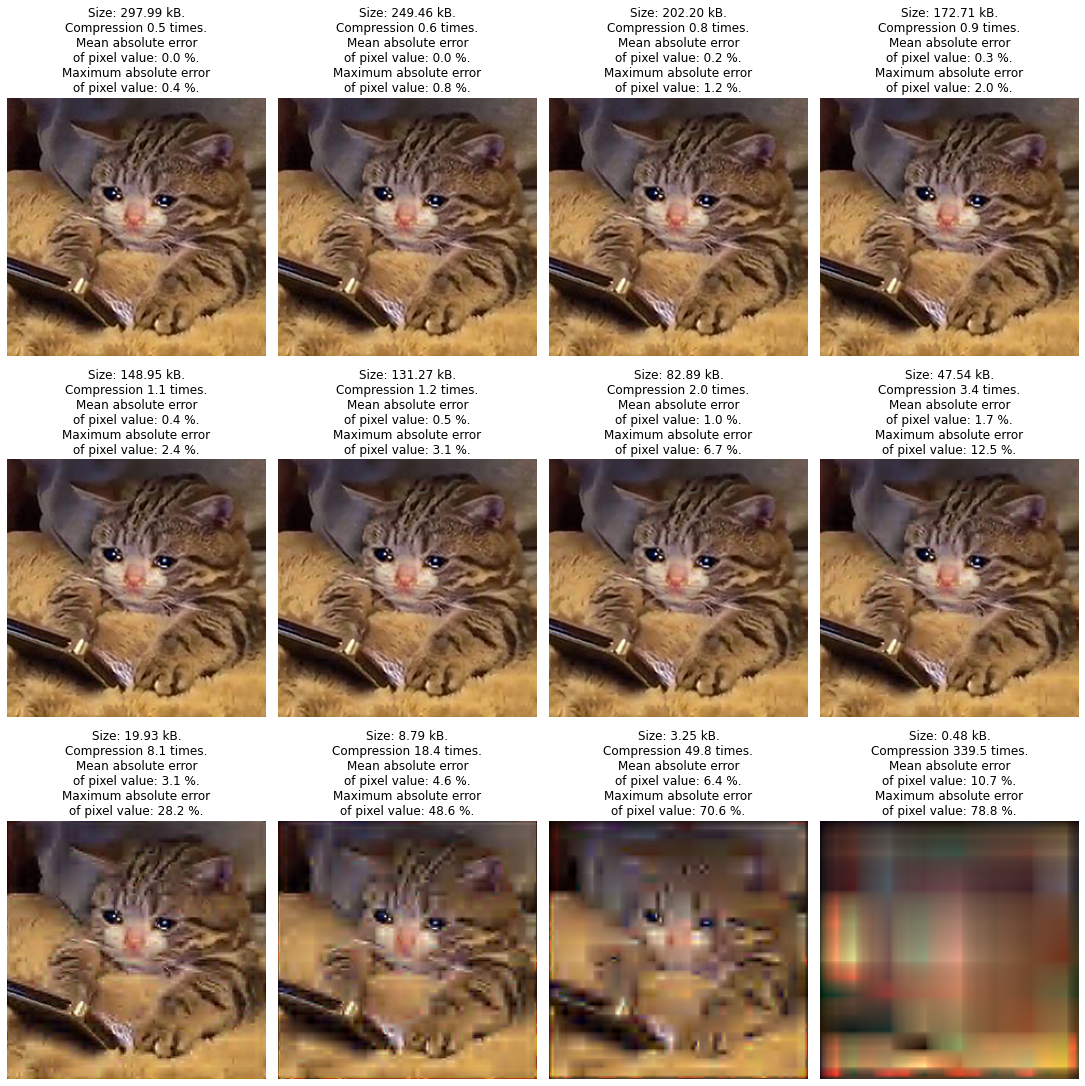

In [4]:
show_gradation('cat.jpg', thresholds, mode='RGB')

  0%|          | 0/12 [00:00<?, ?it/s]

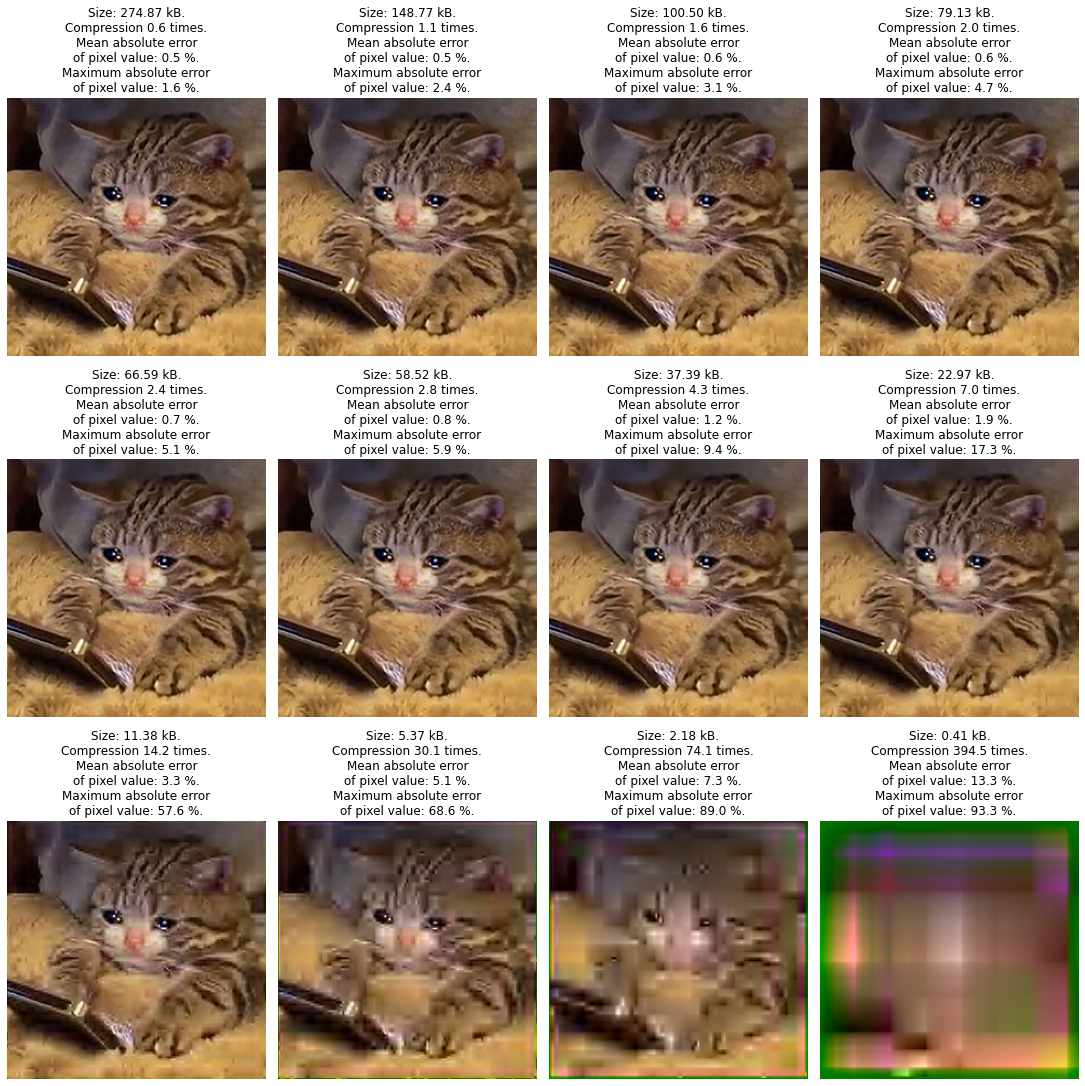

In [5]:
show_gradation('cat.jpg', thresholds, mode='YCbCr')

  0%|          | 0/12 [00:00<?, ?it/s]

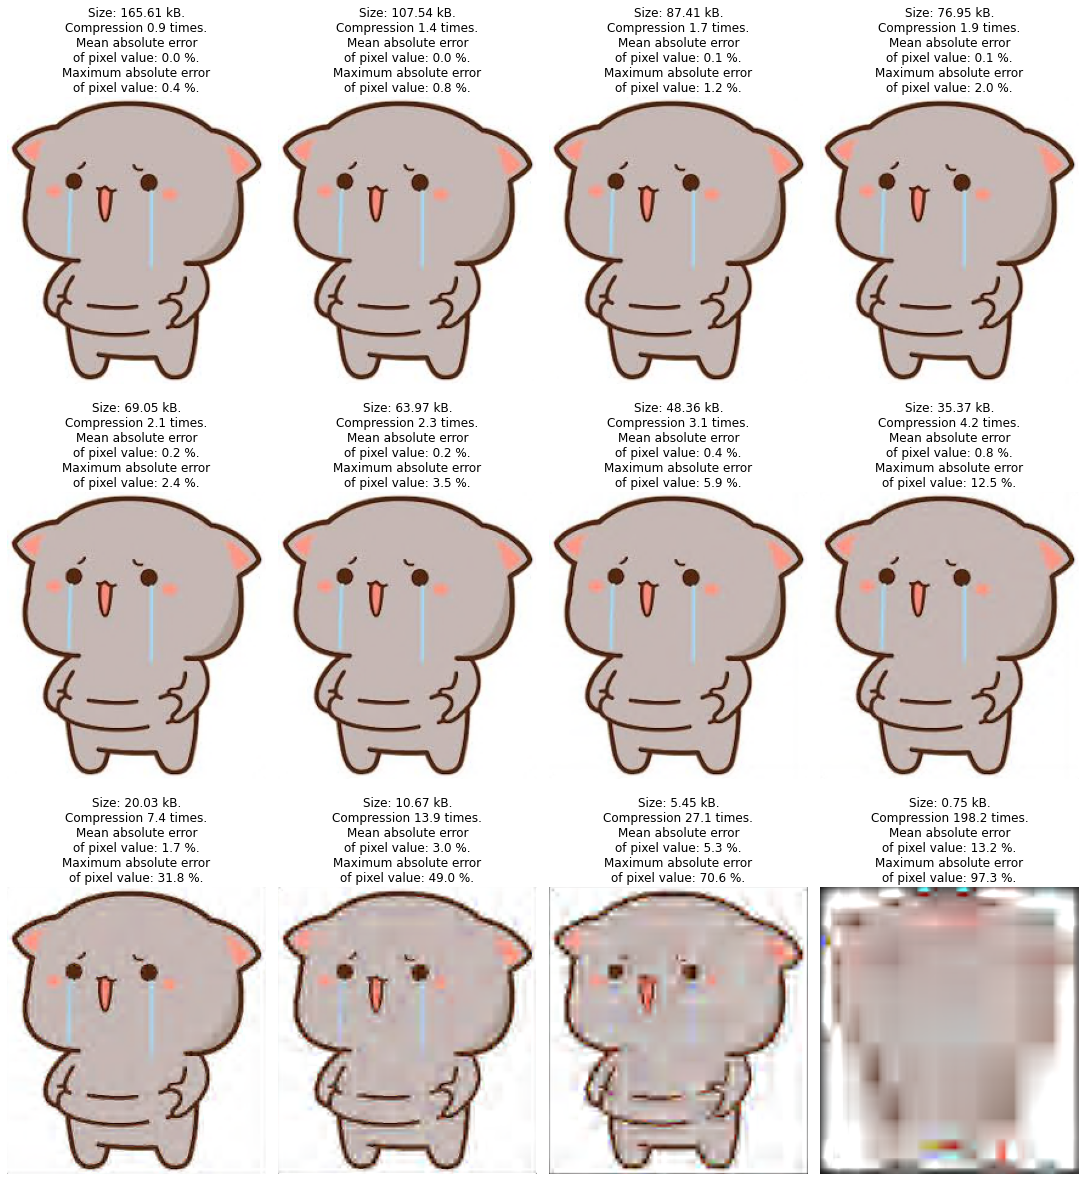

In [6]:
show_gradation('cat_cartoon.jpg', thresholds, mode='RGB')

  0%|          | 0/12 [00:00<?, ?it/s]

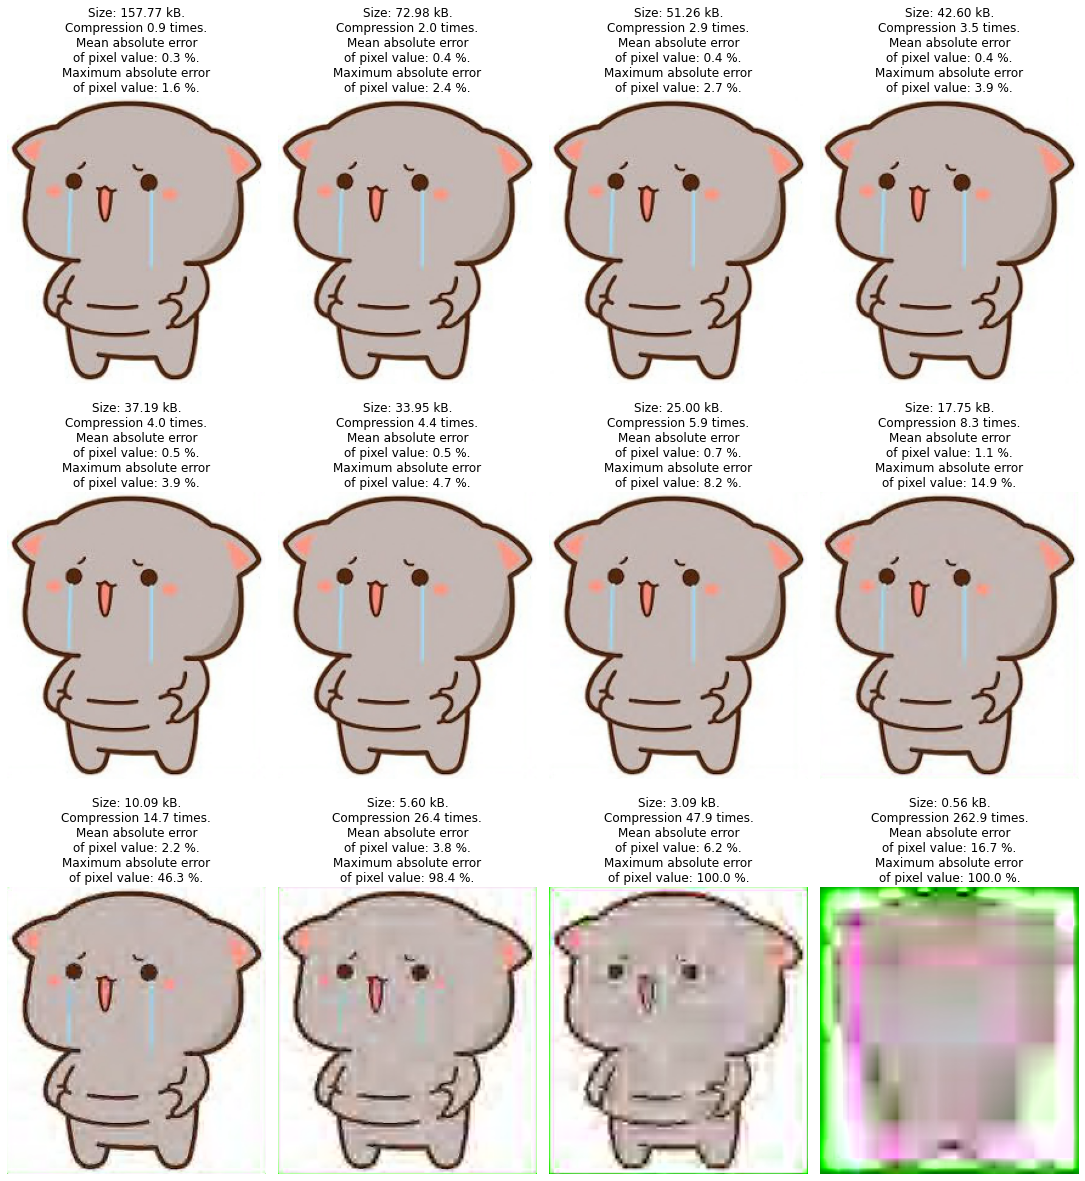

In [7]:
show_gradation('cat_cartoon.jpg', thresholds, mode='YCbCr')

Как видим, изображения сохраняют качество, близкое  исходному, даже после сильного сжатия, и это несомненно преимущества данного метода. Однако посмотрев на первые изобажения в сериях и их характеристики, сразу становится очевидным и главный недостаток: с помощью него нельзя закодировать изображение без потерь, по крайней мере с типом данных 16-bit float. Если его закодировать в 32-bit float, то можно записать информацию без потерь, но, очевидно, размер изображения будет примерно в 2 раза больше. А если посмотреть на изображение с максимально возможным качеством после кодировки с использованием float16, то оно, не дотягивая даже до исходного качества, превышает размер изрображения без какого-либо сжатия аж в два раза. По этой причине демонстрирующий возможность сохранения изображения без потерь не был включен в отчет, ибо выгоднее просто записать информацию о яркости каждого пиксела. Также наблюдается неожиданное явление: в цветовом пространстве YCbCr при визуально одинаковой картинке с RGB изображение может иметь размер почти в два раза меньше. Последнее наблюдение: при высоком уровне сжатия на изображении наблюдаются ровно такие же артефакты, как и у формата JPEG. Таким образом, смотря на изображения, можно сказать, что возможно сжать изображение по размеру примерно в 8 раз без больших ущербов качеству изображения.